In [1]:
from ultralytics import YOLO
import torch

from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd
import os, dotenv, pathlib
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
model = YOLO('./models/yolov8_NII/weights/best.pt').to(device)

In [4]:
def draw_results(result, img, txt_file, colors):
    txt = txt_file.copy()
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 22))

    w, h = img.size
    txt[['xc', 'w']] = txt[['xc', 'w']] * w
    txt[['yc', 'h']] = txt[['yc', 'h']] * h

    ax[0, 0].set_title('Исходное изображение')
    ax[0, 0].imshow(img)

    ax[0, 1].set_title('Ошибки модели')
    ax[0, 1].imshow(img)

    ax[1, 0].set_title('Разметка')
    ax[1, 0].imshow(img)

    ax[1, 1].set_title('Предсказание')
    ax[1, 1].imshow(img)
    
    for cl, x0, y0, w, h in txt.to_numpy():
        ax[1, 0].add_patch(plt.Rectangle((x0-w//2, y0-h//2), w, h, fill=False, color=colors[int(cl)]))
        ax[1, 0].text(x0-w//2, y0-h//2, f'{result.names[cl]}', color='white', fontsize=12)
    
    coordinates = np.concatenate(
        [
            result.boxes.xyxy.cpu(),
            result.boxes.conf.cpu()[:, np.newaxis],
            result.boxes.cls.cpu()[:, np.newaxis]
        ], axis=1)
    for x1, y1, x2, y2, conf, cl in coordinates:
        ax[1, 1].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color=colors[int(cl)]))
        ax[1, 1].text(x1, y2 if cl == 0 else y1, f'{result.names[cl]} {conf*100:.0f}%', color='white', fontsize=12)
    
    pred_cls = result.boxes.cls.cpu()
    true_cls = txt['cl']
    true_boxes = np.array([[x0-w//2, y0-h//2, x0+w//2, y0+h//2] for cl, x0, y0, w, h in txt.to_numpy()])

    for i, (x1, y1, x2, y2, conf, cl) in enumerate(coordinates):
        if not any((pred_cls[i] == true_cls[j]) and (np.allclose([x1, y1, x2, y2], true_boxes[j], atol=20)) for j in range(len(true_cls))):
            ax[0, 1].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='orange'))
            ax[0, 1].text(x1, y1, f'Pred: {result.names[pred_cls[i].int().item()]}', color='white', fontsize=12)

    fig.tight_layout()
    plt.show()

In [5]:
valid_path = pathlib.Path('./basil-count-1/valid/images/')
train_path = pathlib.Path('./basil-count-1/train/images/')
all_images = list(valid_path.iterdir()) + list(train_path.iterdir())

In [6]:
def search(name):
    name = name.split('.')[0].replace(' ', '-').replace('--', '-') + '_jpg'
    for i in all_images:
        if i.stem.split('.')[-3] == name:
            return i
        # print(i.stem.split('.')[-3])


image 1/1 /home/kekwak/Files/НИИ/zero-shot/images/0007-QS-2-8-niz_slice_32.png: 256x96 10 Trs, 8.2ms
Speed: 14.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 96)


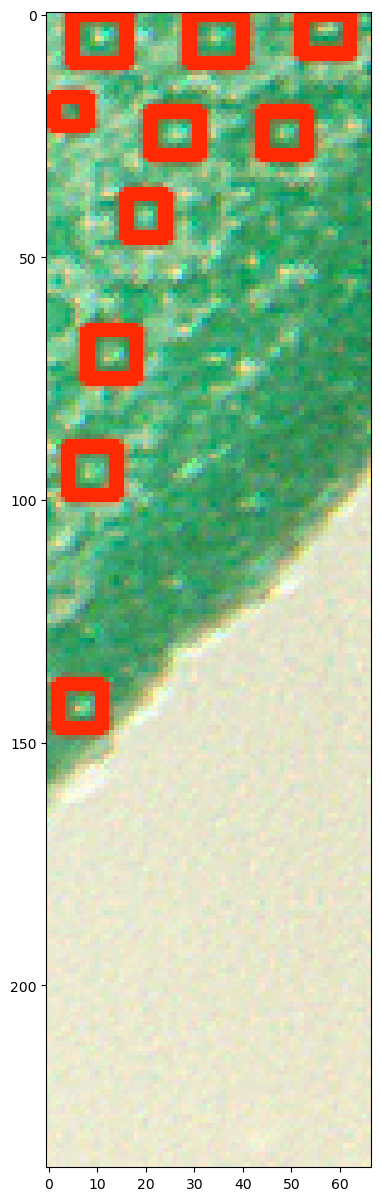

In [45]:
name = '0007-QS-2-8-niz_slice_32.png'
img_path = pathlib.Path(os.path.join('./images', name))
out = model(img_path)[0]

plt.figure(figsize=(15, 15))
plt.imshow(out.plot(labels=False))
plt.show()